# Latent Dirichlet Allocation (LDA) for MR Route Descriptions

In [1]:
import numpy as np
import pandas as pd
import gensim
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

In [2]:
#import data
valid_states = ['Alabama', 'California', 'Georgia', 'Missouri', 'Illinois', 'Ohio',
       'Kentucky', 'Colorado', 'United States', 'Indiana', 'New York',
       'Vermont', 'Texas', 'Florida', 'Minnesota', 'Virginia',
       'Oklahoma', 'Arkansas', 'Maryland', 'West Virginia',
       'Michigan', 'North Carolina', 'Oregon', 'Pennsylvania',
       'Washington', 'New Jersey', 'Alaska',
       'South Carolina', 'Utah', 'New Hampshire', 'Iowa', 'Louisiana',
       'Mississippi', 'Wisconsin',
       'South Dakota', 'Wyoming', 'Massachusetts', 'New Mexico',
       'Montana', 'Idaho', 'Nevada', 'Arizona',
       'Kansas', 'Northeast', 'Southwest', 'Golf Coast', 'Southeast',
       'Tennessee', 'Nebraska', 'Delaware', 'Pacific Coast',
       'Appalachian Mountains', 'Maine', 'Rhode Island', 'Connecticut',
       'North Dakota', 'Hawaii']

route_data_RAW = pd.read_csv('route_data_RAW.csv')
route_data_RAW['description'] = route_data_RAW.agg(lambda x: f"{x['scenery_description']}, {x['drive_enjoyment_description']}, {x['tourism_description']}", axis=1)
route_data_RAW.description

0       The valley road winds beside the Paint Rock Ri...
1       The valley road winds beside the Paint Rock Ri...
2       Drive through a nice slide of Central Alabama ...
3       County Rd 14 west of the Natchez Trace runs al...
4       On this route you will find several homes and ...
                              ...                        
2069    The route travels through the SW Missouri plai...
2070    Goes through vineyards and rolling hills with ...
2071    The route goes through typical mid-Missouri co...
2072    This route has some of the best of the Missour...
2073    There are some beautiful lookout points along ...
Name: description, Length: 2074, dtype: object

In [4]:
#Preprocessing

STOP_WORDS = STOP_WORDS.union({'ll', 've', 'pron',
                                'good','great', 'nice',
                                'ride','route','road','rt','roads'
                              })

## Text Processing

In [45]:
ngram_range = (2,3)
vectorizer = CountVectorizer(ngram_range=ngram_range,
                             stop_words=STOP_WORDS,
                            )
analyzer = vectorizer.build_analyzer()

texts = route_data_RAW.scenery_description.values.tolist()
processed_text = [analyzer(text) for text in texts]

In [46]:
dictionary = gensim.corpora.Dictionary(processed_text)
print('Number of unique tokens: {}'.format(len(dictionary)))

Number of unique tokens: 116123


In [47]:
corpus = [dictionary.doc2bow(t) for t in processed_text]

## Initial LDA Model

In [48]:
#LDA model parameters
num_topics = 2
num_words = 10

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            random_state=17, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

pprint(lda_model.print_topics(num_words=num_words))

[(0,
  '0.005*"rolling hills" + 0.002*"small towns" + 0.002*"national forest" + '
  '0.002*"state park" + 0.002*"river valley" + 0.001*"national park" + '
  '0.001*"tree lined" + 0.001*"farm land" + 0.001*"little traffic" + '
  '0.001*"wooded areas"'),
 (1,
  '0.002*"rolling hills" + 0.002*"state park" + 0.001*"farm land" + '
  '0.001*"national forest" + 0.001*"wide open" + 0.001*"small towns" + '
  '0.001*"river valley" + 0.001*"st louis" + 0.001*"small town" + '
  '0.001*"places stop"')]


In [49]:
# get_document_topics method shows the topics found 
# in each corpus doc
lda_model.get_document_topics(corpus[1])

[(0, 0.026569823), (1, 0.9734302)]

In [50]:
# extracts dominant topic (and percentage) for each comment

def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [51]:
main_topic_df = get_main_topic_df(lda_model, corpus, processed_text)

In [52]:
# len(main_topic_df)

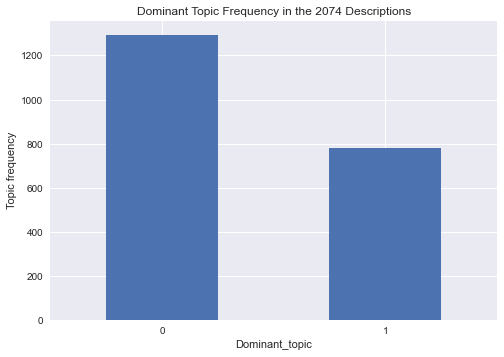

In [53]:
plt.style.use('seaborn')

grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Processed_text'].\
    plot.bar(rot=0).\
    set(title=f'Dominant Topic Frequency in the {len(route_data_RAW)} Descriptions',
        ylabel='Topic frequency');


## Representative data

What's the "most representative" comment we have in the data for each topic?  

In [54]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([ representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(5)])
# representatives
for i in range(len(representatives)):
    print(f'''
        Document: {representatives.index[i]}  
        Dominant topic: {representatives.loc[representatives.index[i]]['Dominant_topic']}\n 
    ''')
    print(texts[representatives.index[i]] + '\n ------- \n')


        Document: 810  
        Dominant topic: 0
 
    
It is 59 miles one-way. Hope others enjoy it as much as I did.  The general scenery you'll see along the way comprises of farm land, timber land, punctuated by old towns, and hills.  
For a more detailed rundown of what you'll see on this ride, keep reading.  This is a trip I took not too long ago that was surpisingly nice (to me.)

Starting at Albany, LA on Highway 190 or from Hammond, make your way west on Highway 190 to Albany. Albany seems like a small community right out of the 1960s with buildings out of the 1940s, perhaps. I am very curous about the Pentacostal Church sign at Hwy 190 and 43; it's the biggest sign around these parts. Not much to Albany except a very leisurely 35 MPH speed limit (Observe it! Not much to do in Albany but ticket speeders and go to church, I think!)
Once you get on Highway 43 North, the ride improves 100%. Very nice rolling turns, not too sharp, and shaded sections of road. Careful of some occ

There seem to be two dominant topics in this set of comments. 

Two types of roads:
1. Roads for the RIDE (Topic 0)
2. Roads for the VIEW (Topic 2)

## Length of documents in each topic

In [55]:
def word_count_by_topic(topic=0):
    d_lens = [len(d) for d in grouped_topics.get_group(topic)['Processed_text']]
    plt.hist(d_lens, bins=50)
    large = plt.gca().get_ylim()[1]
    d_mean = round(np.mean(d_lens), 1)
    d_median = np.median(d_lens)
    plt.plot([d_mean, d_mean], [0,large], label='Mean = {}'.format(d_mean))
    plt.plot([d_median, d_median], [0,large], label='Median = {}'.format(d_median))
    plt.legend()
    plt.gca().set(xlabel='Document word count', ylabel='Number of documents', xlim=(0, 450), 
            title='Distribution of Comment Lengths for {} Comments in Topic {}'.format(len(d_lens), topic));

In [56]:
slider = IntSlider(min=0, max=num_topics-1, step=1, value=0, description='Topic')
interact(word_count_by_topic, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=1), Output()), _dom_classes=('widget-interac…

## Top word distribution per topic

[Text(0, 0.5, 'Word frequency'),
 Text(0.5, 1.0, 'Word Frequencies by Topic, Combining the Top 14 Words in Each Topic')]

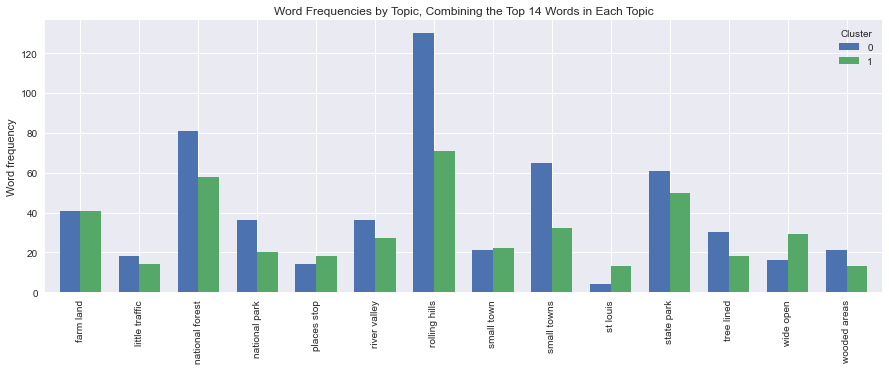

In [57]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)])


words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in lda_top_words_index} 
                       for lst in corpus]

lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']

(
    lda_top_words_df
    .groupby('Cluster').sum().transpose()
    .plot.bar(figsize=(15, 5), width=0.7)
    .set(ylabel='Word frequency', 
         title=f'Word Frequencies by Topic, Combining the Top {len(lda_top_words_index)} Words in Each Topic')
)

## Coherence scores based on number of topics

Coherence scores for the ngram range: (2, 3) 
 [(1, 0.4911214295599162), (2, 0.5436075707473813), (3, 0.4829600283581616), (4, 0.5167982842327203), (5, 0.5360777625878905), (6, 0.5436201249044619), (7, 0.6199922221500077), (8, 0.5852518203343744), (9, 0.6093228188157892), (10, 0.5690703575020952)]


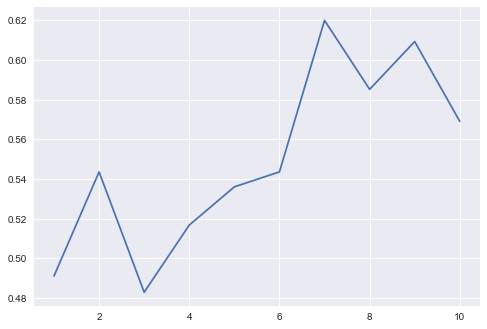

In [58]:
coherence_scores = []

for n in range(1, 11):
    mod = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                          id2word=dictionary,
                                          num_topics=n, 
                                          random_state=117, update_every=1,
                                          chunksize=1500, 
                                          passes=5, iterations=10,
                                          alpha='asymmetric', eta=1/100,
                                          per_word_topics=True)
    cmodel = gensim.models.coherencemodel.CoherenceModel(model=mod,
                                                 texts=processed_text,
                                                 dictionary=dictionary)
    coherence_scores.append((n, cmodel.get_coherence()))
    
topic_range = [coherence_scores[i][0] for i in range(len(coherence_scores))]
cscore = [coherence_scores[i][1] for i in range(len(coherence_scores))]

print(f'Coherence scores for the ngram range: {ngram_range} \n {coherence_scores}')
plt.plot(topic_range,cscore)